Get system informations

In [1]:
import psutil as ps

print(f'frequency : {ps.cpu_freq().current}GHz')
print(f'usage : {ps.virtual_memory().percent}%')

frequency : 3.4995000000000003GHz
usage : 96.0%


After running the test multiple times, those numbers appearto be stable in time

# efficiency of collision

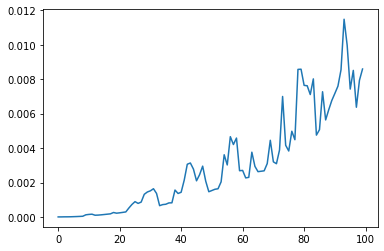

In [2]:
import PhysicsEngine as e
import PhysicsEngine.collision as ecol
import matplotlib.pyplot as plt
import numpy as np
import time

def CreateListOfObjects(n):
  """creates a list of n objects with null properties"""
  obj = []
  for i in range(n):
    obj.append(
        e.object(
            "light",
            1,
            1,
            1,
            1,
            1,
            1
        )
    )
  return obj

# let's graph the time it takes to detect collision for x objects
n = [] # amount of objects
ts = [] #time to check every objects
for i in range(100):
  #create the list of i objects
  obj = CreateListOfObjects(i)
  #teake reference time
  t1 = time.time()
  #does the detection
  col = ecol.DetectCollisions(obj, 0, 1)
  #append the delta
  ts.append(time.time() - t1)
  n.append(i)


#graph it
plt.plot(n, ts)
plt.show()

Running this code multiple time seems to yield the same result. We can clearly see a tendency of the curve to quickly grow in speed at an exponential rate.

**Possible improvements:**
  Parallelizing the process using compute shaders would mean running the detection n times in parallel for each particle. However, it would induce collisuions being detected twice.This issue can be easily solved by pasising the index of the particle to the shader and checking the i+1 to n particles. Getting pairs in a list most likely is a problem that has lalready been visited a lot, research on algorithm can be interesting in this case.

  I cannot find any explanations to the varrying peaks. My best guess is that the clock speed is modified by external factors, which changes the time it takes to compute the checks.


# Precision of the integrator

In order to test the precision we will compare the integrated positions to the one of a circle, when using the circular orbit condition $\dot{\theta}=\sqrt{  \frac{GM}{r^{2}}   (r-\frac{3}{2})  }$ where G is the sum of the mass of the bodies (we neglected the mass of the orbiting body in the physical hypothesis, hence why it will not be present). Let's not forget that we are in polar, so we need to divide it by the radius one more time. However we must not forget the 1st order relativistic equation adding, represented by the additional division of $r-\frac{3}{2}$

0.00823161157653834


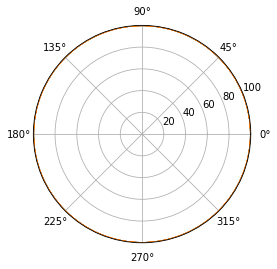

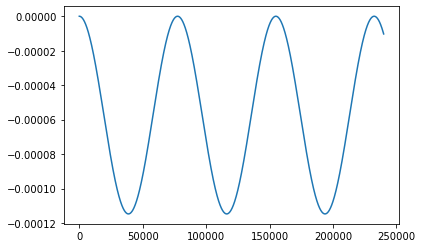

In [3]:
from math import sqrt
# defines the blackhole
bh = e.object("Blackhole", 0,0,0,0,10**12)

r = 100 # we set the radius to 100
#a deltat of 0.01 should be enough
deltat = 0.01

# define the object
# speed = (sqrt( (e.physicalConstants.G * bh.m) / (r**2) * (r-3/2) ))/r
speed = (sqrt( (e.physicalConstants.G * bh.m) / (r**2) * (r+3/2+0.0229) ))/r

print(speed)
obj = e.object("Light", r, 0, 0, speed, 100, 1)
obj.Updatel0()

fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})

# makes the r and theta for the projectile using the integrator
for i in range(20*12000):#arbitrary but seems like it contains a full orbit
  e.nbody_coupled_integrator(obj, bh, deltat)

ax.plot(obj.theta_list, obj.r_list)

# same for a perfect circle
cr = np.array(obj.theta_list)# we need to use the same thetas
ct = np.array([r for i in range(len(cr))])
ax.plot(cr, ct)

plt.show()
# let's see the difference between a perfect circle and a should be perfect orbit.
deltas = [(r-obj.r_list[i]) for i in range(len(cr))]
plt.plot([x for x in range(len(deltas))], deltas)

plt.show()





We seem to have an error in the starting speed. After running the simulation for multiple black hole masses, the results does not seem to vary. The orbit always looks the same. with a variation to maximum ~6 units of the radius. Three variants have been tried, using 30, 100 and 300 as a starting radius. I also tried with different black hole masses (10^11 and 10^12), the variation never increases or decreases. This is likely due to the precision of the value we use. We can however note that for multiple orbits, the system stays very stable and does not diverge quickly.

However, switching the minus to a plus in the 1st order correction seems to yield better results. There must be errors in my calculations to find the speed in a circular orbit. Doing so reduces the error from 6 to just under 0.05 Rs. Adding another value to the 3/2 between 0.0228 and 0.229 lowers that error even more.

# Conservation of energy during impacts

In order to test if the simulation is physically accurate, we will check the conservation of energy in the angular momentum $l0$ after having multiple collisions. In order to do that we will simulate to balls on similar orbits bouncing on eachothers multiple times.

2
0.0
[(0, 1)]
1.4210854715202004e-14
[(0, 1)]
-7.105427357601002e-15
[(0, 1)]
1.6200374375330284e-12
[(0, 1)]
-1.1176837233506376e-11
[(0, 1)]
1.900062329696084e-10
object escape, remaining objects before pop : 2, iteration number 0
object escape, remaining objects before pop : 2, iteration number 0
depop <PhysicsEngine.engine_rev2.object object at 0x7fcea07a4040>
depop <PhysicsEngine.engine_rev2.object object at 0x7fce6ee64d60>


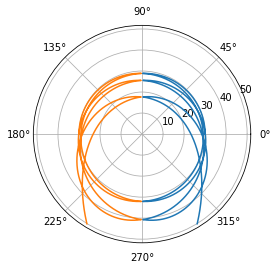

In [4]:
#reset all variables for some reasons its needed
%reset -f


from math import sqrt
import PhysicsEngine as e
import matplotlib.pyplot as plt

#Create the objects list
bh = e.object("Blackhole", 0,0,0,0,10**12)

r = 30
speed = 0.05
test_objs = [
    e.object("Heavy", r, 0, 0, speed, 1e2, 0.5),
    e.object("Heavy", r, e.pi, 0, -speed, 1e2, 0.5)
]


print(len(test_objs))

def GetL0Sum(objs):
  s = 0
  for i in objs:
    s+= i.l0
  return s


deltat = 0.0000001

print(GetL0Sum(test_objs))
for i in range(10000000):
  (outs, test_objs, deltat, dt_list, col_list, col_pairs) = e.game_physics_loop(test_objs, bh, 1, deltat)

  if col_pairs != []:
    print(col_pairs)
    print(GetL0Sum(test_objs))

  if len(test_objs) == 0:
    break



fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
for i in outs:
  ax.plot(i.theta_list, i.r_list)


plt.show()


We use a really small deltat. for this part as precision is necessary. We can see that the sums of $l0$ do vary and is not always null. The firt sum is null as the system is symetrical. The variation is really small, and is most likely due to numerical noise.